In [1]:
import os
os.chdir('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

from scipy.stats import pearsonr, spearmanr, zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

### Annotations

- df: contains results for train and val video splits (use this to train and validate the bias-predictor)
- test: results for test split, use this only to see the final results

In [2]:
data = pd.read_csv('inference_feat.csv')
data['error'] = data['true_ef'] - data['predicted_ef']

df = data[(data['split'] == 'TRAIN') | (data['split'] == 'VAL')]
test = data[ data['split'] == 'TEST' ]

### Resnet50-UNet Segmentation and Heuristic estimation of EF

In [3]:
predictions = test['predicted_ef']
true_values = test['true_ef']

mean_absolute_error(true_values, predictions)

6.429275796053563

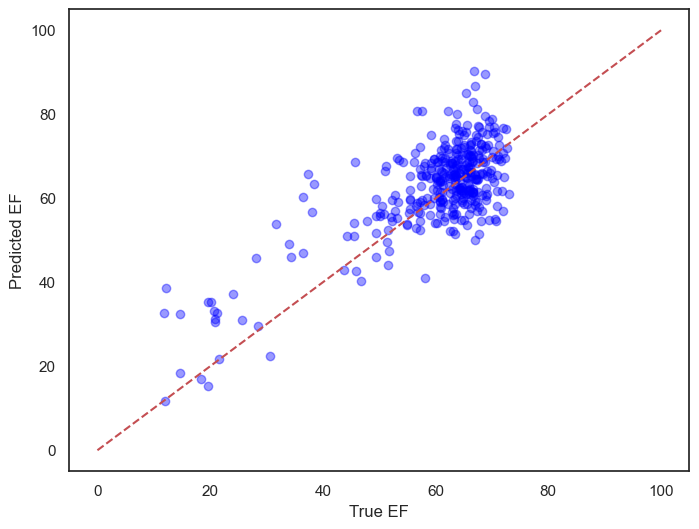

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(test['true_ef'], test['predicted_ef'], alpha=0.4, color='blue')
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel("True EF")
plt.ylabel("Predicted EF")
plt.show()

### Bias Predictor

- The idea is to build a machine learning model that predicts the signed error between the true and (heuristic) predicted ejection fraction
- Take as input geometric features from frame-by-frame segmentation

### Signed Error Distribution

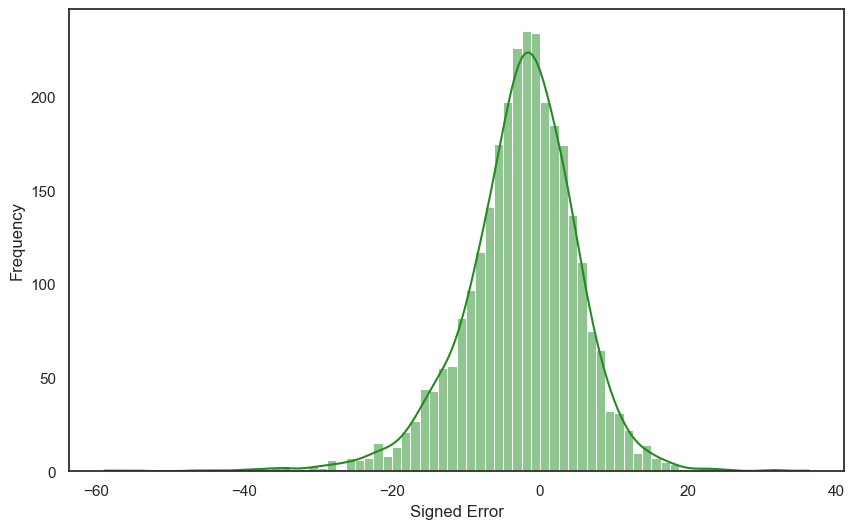

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(df['error'], color='forestgreen', kde=True)
plt.ylabel('Frequency')
plt.xlabel('Signed Error')
plt.show()

In [6]:
df.describe()

,true_ef,predicted_ef,volume_ratio,length_ratio,dice_overlap_std,dice_overlap_ratio,error
count,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000
mean,61.045711,63.603096,0.363969,0.721942,0.020708,0.893945,-2.557385
std,10.379105,9.793368,0.097934,0.066321,0.010466,0.055804,7.853100
min,7.020000,9.483829,0.000104,0.039866,0.004027,0.009852,-58.843067
25%,59.650000,59.907665,0.308881,0.688220,0.014394,0.876666,-6.674831
50%,63.475000,64.825132,0.351749,0.722981,0.018713,0.903855,-1.977281
75%,67.012500,69.111868,0.400923,0.755744,0.024063,0.926846,2.286076
max,72.970000,99.989601,0.905162,0.960815,0.168302,0.983087,36.321115


### Z-score outliers deletion

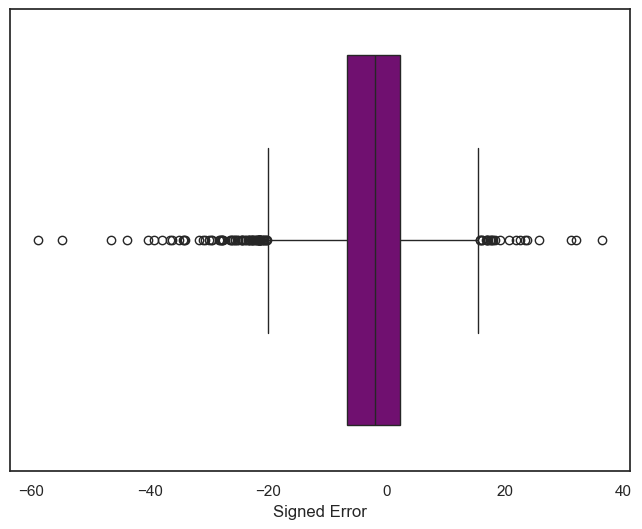

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['error'], color='purple')
plt.xlabel('Signed Error')
plt.show()

In [8]:
z = np.abs(zscore(df['error']))
filtered_df = df[(z < 2)]

print('original data shape: ', df.shape)
print('no-outliers data shape: ', filtered_df.shape)

original data shape:  (2912, 9)
no-outliers data shape:  (2772, 9)


In [9]:
df = filtered_df

In [10]:
df.drop(columns=['filename', 'split', 'true_ef', 'predicted_ef'], inplace=True)

In [11]:
X, y = df.drop('error', axis=1), df['error']

In [12]:
matrix = X.join(y).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))

<Axes: >

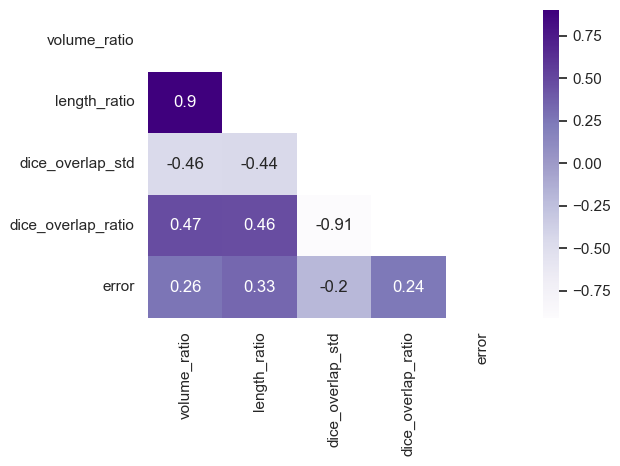

In [13]:
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, annot=True, cmap='Purples', mask=mask)

<Axes: xlabel='volume_ratio', ylabel='length_ratio'>

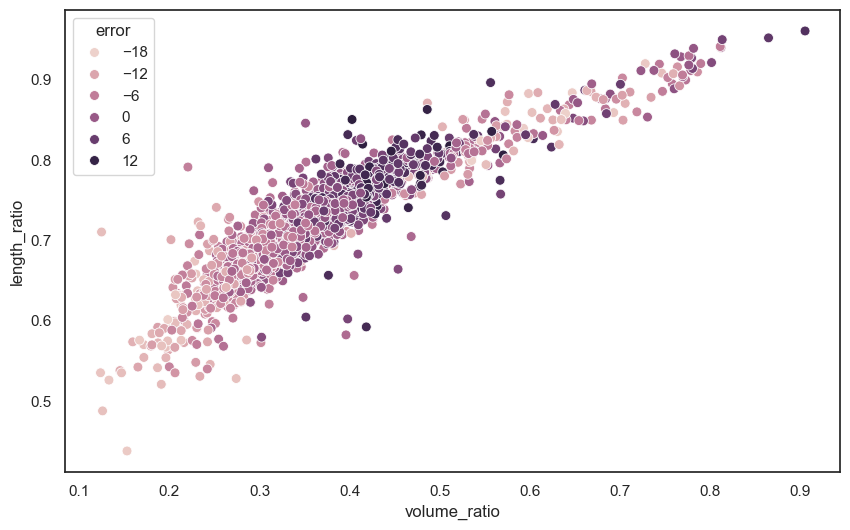

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='volume_ratio', y='length_ratio', data=X, hue=y, s=50)

In [15]:
features = ['volume_ratio', 'length_ratio', 'dice_overlap_std']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=1)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=1)),
    ('K-Nearest Neighbors', KNeighborsRegressor())
]

In [17]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_value = mean_absolute_error(y_test, y_pred)
    mse_value = mean_squared_error(y_test, y_pred)
    r2_value = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae_value,
        'MSE': mse_value,
        'R^2': r2_value
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='R^2', ascending=False, inplace=True)
results_df

,Model,MAE,MSE,R^2
1,Gradient Boosting,3.911048,26.991312,0.261009
0,Random Forest,4.052565,27.856274,0.237327
2,K-Nearest Neighbors,4.248252,30.141946,0.174748


In [18]:
reg = GradientBoostingRegressor()

param_grid = {
    'random_state': [1],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X[features], y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200], 'random_state': [1]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
X_test = test[features]
y_test = test['error']

In [20]:
reg = grid.best_estimator_
y_pred = reg.predict(X_test)

mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print('MAE:', mae_value)
print('MSE:', mse_value)
print('R^2:', r2_value)

MAE: 4.69592986731401
MSE: 40.71412043976519
R^2: 0.3552089701852569


Text(0, 0.5, 'Predicted EF')

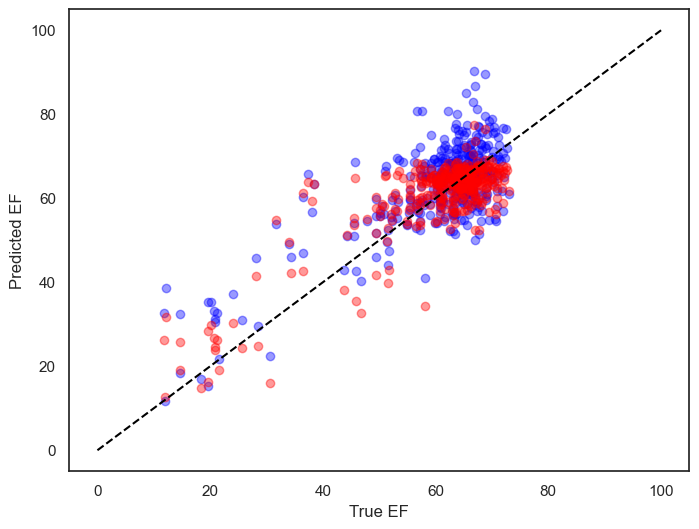

In [21]:
plt.figure(figsize=(8, 6))
plt.plot([0, 100], [0, 100], '--', color='black')
plt.scatter(true_values, predictions, alpha=0.4, color='blue')
plt.scatter(true_values, predictions + y_pred, alpha=0.4, color='red')
plt.xlabel("True EF")
plt.ylabel("Predicted EF")

In [22]:
print('Original MAE: ', mean_absolute_error(true_values, predictions))
print('New MAE: ', mean_absolute_error(true_values, predictions + y_pred))

Original MAE:  6.429275796053563
New MAE:  4.69592986731401


In [23]:
test = data[data['split'] == 'TEST'].copy()
test.loc[:, 'corrected_ef'] = test['predicted_ef'] + y_pred

In [24]:
diff_original = test['true_ef'] - test['predicted_ef']
mean_original = (test['true_ef'] + test['predicted_ef']) / 2

diff_corrected = test['true_ef'] - test['corrected_ef']
mean_corrected = (test['true_ef'] + test['corrected_ef']) / 2

### Bland-Altman Plots for Agreement Analysis

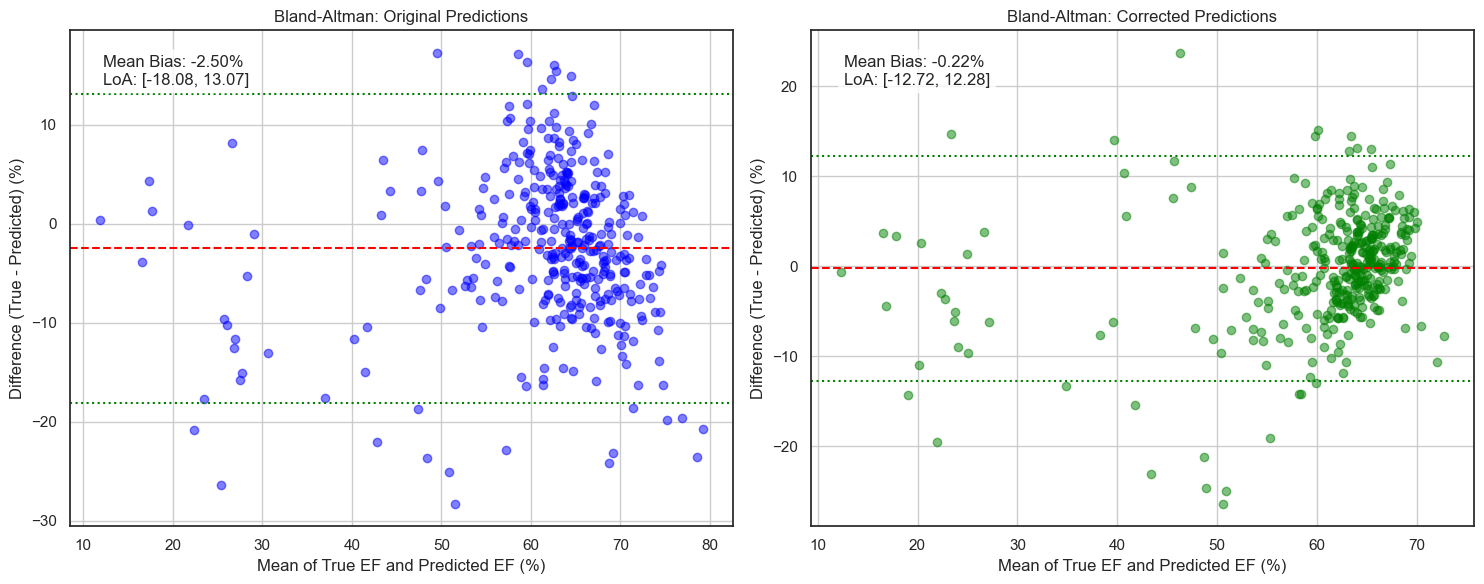

In [25]:
def bland_altman_plot(mean, diff, title, color='b', ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(mean, diff, alpha=0.5, color=color)
    
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff
    
    ax.axhline(mean_diff, color='red', linestyle='--')
    ax.axhline(loa_upper, color='green', linestyle=':')
    ax.axhline(loa_lower, color='green', linestyle=':')
    
    ax.set_title(title)
    ax.set_xlabel('Mean of True EF and Predicted EF (%)')
    ax.set_ylabel('Difference (True - Predicted) (%)')
    ax.text(0.05, 0.95, 
            f'Mean Bias: {mean_diff:.2f}%\nLoA: [{loa_lower:.2f}, {loa_upper:.2f}]', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

bland_altman_plot(mean_original, diff_original,  "Bland-Altman: Original Predictions", 'blue', ax1)

bland_altman_plot(mean_corrected, diff_corrected, "Bland-Altman: Corrected Predictions", 'green', ax2)

plt.tight_layout()
plt.show()

##### **Original Predictions**
- **Systematic Bias**: -2.50% (consistent overestimation)
- **Limits of Agreement (LoA)**: -18.08% to 13.07% (31.15% spread)
- **Key Issues**:  
  - Clinically significant bias  
  - Wide error dispersion  
  - Maximum potential error: 18.08% underestimation

##### **After Regression Correction**
- **Systematic Bias**: -0.22% (clinically negligible)
- **Limits of Agreement (LoA)**: -12.72% to 12.28% (25% spread)
- **Key Improvements**:  
  -  2.28% bias reduction  
  -  19.7% narrower agreement range 
  -  Tighter clustering around zero bias line  
  -  Fewer points outside LoA boundaries  
  -  More consistent errors across EF range  
  -  Maximum error reduced  by 29.6% (18.08% → 12.72%)

### **Normality Test**

In [26]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

test = test.copy()
test['abs_error_original'] = np.abs(test['true_ef'] - test['predicted_ef'])
test['abs_error_corrected'] = np.abs(test['true_ef'] - test['corrected_ef'])

test['error_diff'] = test['abs_error_original'] - test['abs_error_corrected']

In [28]:
from statsmodels.stats.diagnostic import lilliefors

differences = test['error_diff']

lilliefors_statistic, lilliefors_p_value = lilliefors(differences, dist='norm')

print(f"\nKolmogorov-Smirnov (Lilliefors) Test:")
print(f"  Statistic = {lilliefors_statistic:.4f}")
print(f"  p-value   = {lilliefors_p_value:.4f}")


Kolmogorov-Smirnov (Lilliefors) Test:
  Statistic = 0.1529
  p-value   = 0.0010


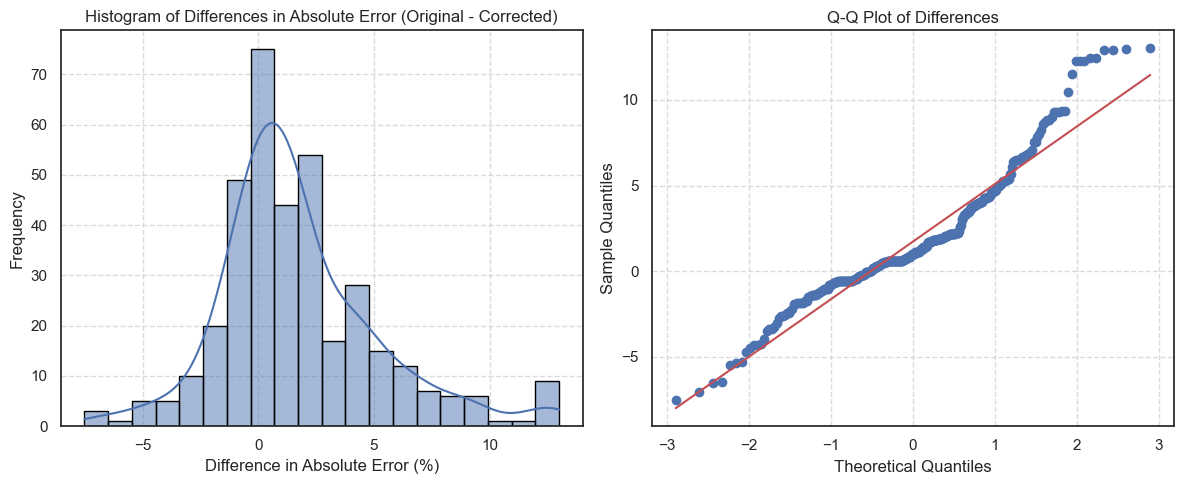

In [ ]:
from scipy.stats import probplot

differences = test['error_diff']

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(differences, bins=20, kde=True, edgecolor='black')
plt.title('Histogram of Differences in Absolute Error (Original - Corrected)')
plt.xlabel('Difference in Absolute Error (%)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(differences, dist="norm", plot=plt)
plt.title('Q-Q Plot of Differences')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Statistical Test Results
- **Kolmogorov-Smirnov Test**:  
  `D = 0.1601, p = 0.0010`

**Interpretation**:  
**Strongly rejects normality** (p < 0.05) despite the histogram appearing approximately normal.

#### Wilcoxon Signed-Rank Test (non-parametric)

In [ ]:
wilcoxon_result = stats.wilcoxon(test['abs_error_original'], 
                                 test['abs_error_corrected'],
                                 alternative='greater')

# Bootstrap Confidence Interval
n_boot = 10000
boot_means = []
for _ in range(n_boot):
    sample = np.random.choice(test['error_diff'], 
                             size=len(test), 
                             replace=True)
    boot_means.append(np.mean(sample))
ci = np.percentile(boot_means, [2.5, 97.5])

print(f"Wilcoxon p-value: {wilcoxon_result.pvalue:.6f}")
print(f"95% CI for Mean Improvement: [{ci[0]:.3f}, {ci[1]:.3f}]")

Wilcoxon p-value: 0.000000
95% CI for Mean Improvement: [1.380, 2.096]


##### **1. Wilcoxon p-value: 0.000000**

**Statistical Significance:**
- Extremely small p-value (p < 0.000001) provides **overwhelming evidence** that regression correction significantly improves EF predictions
- The null hypothesis (H₀: "No difference between original and corrected errors") is decisively rejected

**Practical Meaning:**
- There's virtually **zero probability** that the observed improvement occurred by random chance

---

##### **2. 95% CI for Mean Improvement: [1.380, 2.096]**

**Statistical Significance:**
- We are **95% confident** the true mean error reduction across all possible cases is between 1.380% and 2.096% EF points
- The interval **doesn't contain zero** (all values positive), confirming systematic improvement

**Practical Meaning:**
- On average, correction **reduces prediction error by 1.74% EF** (midpoint of CI)
- **Conservative estimate**: Minimum expected improvement = 1.38% EF
- **Optimistic estimate**: Maximum expected improvement = 2.10% EF
